In [173]:
import sympy as sp

t = sp.Symbol('t', positive=True)
t_prime = sp.Symbol("t'", positive=True)
x1 = sp.Symbol('x1')
x0 = sp.Symbol('x0')

def b_kernel(t_val, t_prime_val):
  return sp.Min(t_val, t_prime_val)

def OB_kernel(t_val, t_prime_val):
  return sp.exp(-sp.Abs(t_val - t_prime_val))



In [174]:
# Extract observation points and function values
kernel = OB_kernel
t_obs = sp.Matrix([0,1])
f_obs = sp.Matrix([x0,x1])

print('twtw')

# Create the covariance matrix K
K = sp.Matrix([[kernel(t_obs[0],t_obs[0]),kernel(t_obs[0],t_obs[1])],[kernel(t_obs[1],t_obs[0]),kernel(t_obs[1],t_obs[1])]])


print(sp.latex(K))

# Calculate the pseudo-inverse of K
K_plus = K.pinv() # double check this!!!
K_plus = sp.simplify(K_plus)
print(sp.latex(K_plus))
# Create the vector of covariances between x and the observation points
kappa_vec = sp.Matrix([kernel(t_obs[0],t),kernel(t_obs[1],t)])
print(sp.latex(kappa_vec))
sp.pretty_print(kappa_vec)
kappa_vec2 = sp.Matrix([kernel(t_obs[0], t_prime), kernel(t_obs[1], t_prime)])
print(sp.latex(kappa_vec2))
sp.pretty_print(kappa_vec2)
# Calculate the posterior mean
posterior_mean = kappa_vec.T @ K_plus @ sp.Matrix(f_obs)

# Calculate the posterior covariance (optional)
posterior_covariance =  sp.Matrix([kernel(t, t_prime)]) - kappa_vec.T @ K_plus @ kappa_vec2

twtw
\left[\begin{matrix}1 & e^{-1}\\e^{-1} & 1\end{matrix}\right]
\left[\begin{matrix}- \frac{e^{2}}{1 - e^{2}} & - \frac{1}{2 \sinh{\left(1 \right)}}\\- \frac{1}{2 \sinh{\left(1 \right)}} & - \frac{e^{2}}{1 - e^{2}}\end{matrix}\right]
\left[\begin{matrix}e^{- t}\\e^{- \left|{t - 1}\right|}\end{matrix}\right]
⎡    -t   ⎤
⎢   ℯ     ⎥
⎢         ⎥
⎢ -│t - 1│⎥
⎣ℯ        ⎦
\left[\begin{matrix}e^{- t'}\\e^{- \left|{t' - 1}\right|}\end{matrix}\right]
⎡    -t'   ⎤
⎢   ℯ      ⎥
⎢          ⎥
⎢ -│t' - 1│⎥
⎣ℯ         ⎦


In [175]:

latex_code = sp.latex(sp.simplify(posterior_covariance[0]))

print(latex_code)

\left(\frac{e^{- \left|{t - 1}\right|}}{2 \sinh{\left(1 \right)}} + \frac{e^{2} e^{- t}}{1 - e^{2}}\right) e^{- t'} + \left(\frac{e^{2} e^{- \left|{t - 1}\right|}}{1 - e^{2}} + \frac{e^{- t}}{2 \sinh{\left(1 \right)}}\right) e^{- \left|{t' - 1}\right|} + e^{- \left|{t - t'}\right|}


In [176]:
latex_code = sp.latex(posterior_covariance[0].subs(t_prime,t))
print(latex_code)


- \left(- \frac{e^{- \left|{t - 1}\right|}}{2 \sinh{\left(1 \right)}} - \frac{e^{2} e^{- t}}{1 - e^{2}}\right) e^{- t} - \left(- \frac{e^{2} e^{- \left|{t - 1}\right|}}{1 - e^{2}} - \frac{e^{- t}}{2 \sinh{\left(1 \right)}}\right) e^{- \left|{t - 1}\right|} + 1


In [177]:
posterior_mean = posterior_mean.subs(x0, 1)
posterior_mean = posterior_mean.subs(x1, 2)
mean_func = sp.lambdify(t,posterior_mean[0])
print(mean_func(0.5))

1.3302283259551109


In [178]:
covariance_func = sp.lambdify((t,t_prime),posterior_covariance[0])

(20, 500)
(500,)


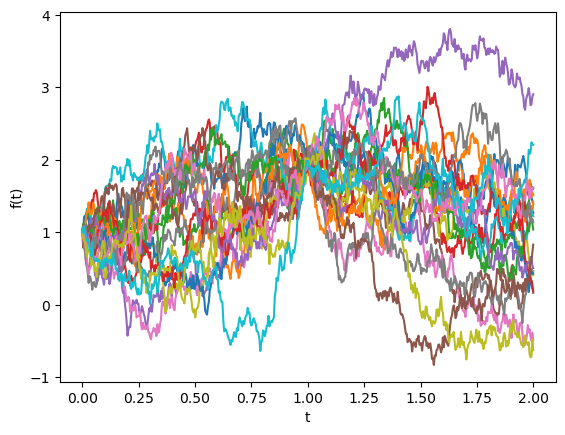

In [179]:
import numpy as np
import matplotlib.pyplot as plt

def sample_gp(mean_func, cov_func, num_samples=5, num_points=100):
  """Samples a Gaussian Process and returns the samples.

  Args:
    mean_func: Function that calculates the mean.
      Should take an array of x values as input and return an array of mean values.
    cov_func: Function that calculates the covariance matrix.
      Should take an array of x values as input and return a covariance matrix.
    x_range: Tuple (x_min, x_max) defining the range of x values to sample.
    num_samples: Number of sample functions to generate.
    num_points: Number of grid points to discretize the domain.

  Returns:
    A tuple (x, samples) where:
      x: Array of x values.
      samples: A NumPy array of shape (num_samples, num_points) containing the samples.
  """

  t_min = 0
  t_max = 2
  ts = np.linspace(t_min, t_max, num_points)  # Discretize the domain
  t_primes = np.linspace(t_min, t_max, num_points)  # Discretize the domain
  K = np.zeros((num_points, num_points))  # Initialize covariance matrix
  mean = []
  for t in ts:
    mean.append(mean_func(t))  # Evaluate the mean vector
  for row in range(num_points):
    for col in range(num_points):
      K[row,col] = cov_func(ts[row],t_primes[col])

  mean = np.array(mean)
  # Cholesky decomposition
  C = np.linalg.cholesky(K + 1e-15*np.eye(num_points))  # Add jitter for numerical stability

  # Sample Z
  Z = np.random.normal(size=(num_points, num_samples))  

  # Generate samples f = m + C^T * Z
  samples = mean[:, np.newaxis] + C @ Z  
  samples = samples.T  # Transpose to have shape (num_samples, num_points)

  return ts, samples

def func(t):
  return 0
def func2(t, t_prime):
  return np.min([t, t_prime])


number_of_samples = 20
x, samples = sample_gp(mean_func, covariance_func, num_points=500, num_samples=number_of_samples)

# Now you can use x and samples for plotting or further analysis
# For example, to plot the first 5 samples:

print(samples.shape)
print(x.shape)
for i in range(number_of_samples):
  plt.plot(x, samples[i, :])
plt.xlabel('t')
plt.ylabel('f(t)')
plt.show()